![](https://drive.google.com/uc?export=view&id=1-5X9OUkA-C2Ih1gOS9Jd7GmkTWUEpDg1)

**Asignatura:** *Deep Learning*

**Profesor:** Juan Bekios Calfa


---



# Laboratorio 2: Redes neuronales poco profundas y apredizaje

En este tutorial veremos dos implementaciones en Pytorch una con clasificación lineal multiclase y otra utilizando una red neuronal poco profunda. La idea es poder comparar el rendimiento de ambos clasificadores.

Como se verá, los modelos de entrenamiento implementados en Pytorch requieren mucoh menos código que es escribir un proyecto desde cero como se vió en el laboratorio 1.

Sin embargo, Pytorch oculta muchos detalles en sus cálculos. Que serán estudiados aquí. 

**Objetivos:**
- Estudiar el conjunto de base de datos MNIST, que contiene imágenes de $28\times 28$ píxeles escritos a mano.
- Introducir el uso de Pytorch para construir y entrenar modelos
- Explorar ajustes del modelo: Tamaño del conjunto de datos, tamaño del *batch* y regularización.

**Base de datos**

El conjunto de datos del MNIST contiene dígitos (numéricos) escritos a mano en blanco y negro de $28\times 28$ píxeles de tamaño. Este es un
conjunto de datos que se utiliza típicamente para demostraciones de modelos de aprendizaje de automático, y como un primer conjunto de datos para probar nuevos
tipos de modelos.

Para el laboratorio descargaremos este conjunto de datos. Para simplificar, sólo usaremos las primeras 2500 imágenes del conjunto de datos del MNIST.

In [ ]:
from torchvision import datasets

# Cargar el conjunto de datos
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_train = list(mnist_train)[:2500]

print(mnist_train[0])

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



(<PIL.Image.Image image mode=L size=28x28 at 0x7F4694C73E80>, 5)


## 1. Visualizando y explorando los datos

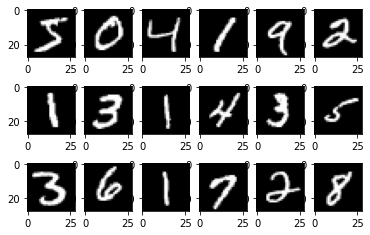

In [ ]:
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(mnist_train[:18]):
  plt.subplot(3, 6, k+1)
  plt.imshow(image, cmap='gray')

PyTorch tiene funciones convertir una imagen en características numéricas de píxeles. El tensor aún conserva el 2D
geometría de la imagen (aún obtenemos una forma de $1\times 28\times 28$) y aún no aplana la imagen en un vector (para obtener un $1\times 784$
forma).

## 2. Preparando los datos

In [ ]:
from torchvision import transforms
# transformamos el tipo de dato de imagen a una matriz de 28x28
img_to_tensor = transforms.ToTensor()
# convertir la última imagen vista (8) dentro de un tensor.
print(image)
img_tensor = img_to_tensor(image)
img_tensor.shape

<PIL.Image.Image image mode=L size=28x28 at 0x7F46947F61D0>


torch.Size([1, 28, 28])

Si queremos convertir la base de datos completa a representación de tipo Tensor. Se puede cargar de la siguiente forma:

In [ ]:
mnist_train = datasets.MNIST('data', train=True, transform=img_to_tensor)
mnist_train = list(mnist_train)[:2500]

print('Tamaño de la imagen',mnist_train[0][0].shape)
print('Tamaño de la imagen',mnist_train[0][1])

Tamaño de la imagen torch.Size([1, 28, 28])
Tamaño de la imagen 5


Ahora, dividiremos estos datos en entrenamiento y validación, y empezaremos a construir nuestro modelo. No necesitaremos un conjunto de pruebas para esto
pero en general también tendremos un conjunto de pruebas

In [ ]:
mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]

## 3. Modelo red neuronal poco profunda multiclass con Pytorch

Lo primero que debemos hacer es importar torch y algunos módulos de esta librería:

*  **torch.nn:** La librería de redes neuronales que utilizaremos para crear nuestro modelo.
*  **torch.autograd:** En concreto el módulo Variable de esta librería que se encarga de manejar las operaciones de los tensores.
*  **torchvision.datasets:** El módulo que ayudará a cargar el conjunto de datos que vamos a utilizar y explicaremos más adelante.
*  **torchvision.transforms:** Este módulo contiene una serie de funciones que nos ayudarán modificando el dataset.
*  **torch.optim:** De aquí usaremos el optimizador para entrenar la red neuronal y modificar sus pesos.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim

### Preparamos los dataloader

In [18]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_val,
                batch_size=batch_size,
                shuffle=False)

 Para saber la cantidad de lotes o batches se ejecuta el comando `len`.

In [19]:
print ('Trainning batch number: {}'.format(len(train_loader)))
print ('Testing batch number: {}'.format(len(test_loader)))

Trainning batch number: 63
Testing batch number: 16


### Crear el modelo 

Para este laboratorio crearemos una red neuronal poco profunda con una entrada de 784 dimensiones (28x28 pixels), una capa oculta de 256 neuronas y una capa de salida de 10 dimensiones, una por cada número o categoría a clasificar.

In [22]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)#capa oculta
        self.fc2 = nn.Linear(256, 10)#capa de salida
        self.loss_criterion = nn.CrossEntropyLoss()#Función de pérdida
        
    def forward(self, x, target):
        x = x.view(-1, 28*28)#transforma las imágenes de tamaño (n, 28, 28) a (n, 784)
        x = F.relu(self.fc1(x))#Función de activación relu en la salida de la capa oculta
        x = F.softmax(self.fc2(x), dim=1)#Función de activación softmax en la salida de la capa oculta
        loss = self.loss_criterion(x, target)#Calculo de la función de pérdida
        return x, loss

In [23]:
# Optimización
model = MLP()
optimizar = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## 4. Entrenamiento del modelo

Para entrenar y validar el modelo se crea una clase para ordenar cada uno de los componentes.

(Fuente:[Link](https://cleverpy.com/primera-red-neuronal-con-pytorch/))

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim
import time

CUDA = torch.cuda.is_available()

class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)#capa oculta
        self.fc2 = nn.Linear(256, 10)#capa de salida
        self.loss_criterion = nn.CrossEntropyLoss()#Función de pérdida
        
    def forward(self, x):
        x = x.view(-1, 28*28)#transforma las imágenes de tamaño (n, 28, 28) a (n, 784)
        x = F.relu(self.fc1(x))#Función de activación relu en la salida de la capa oculta
        x = F.softmax(self.fc2(x), dim=1)#Función de activación softmax en la salida de la capa oculta
        return x
        

class NN():
    def __init__(self):
        self.model = NET()
        if CUDA:
            # Modelo se ejecuta sobre GPU
            self.model.cuda()
        # Ejecuta sobre CPU
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

    def epoch_step(self, dataset_loader, train=False, verbose=2):
        correct_cnt, ave_loss = 0, 0#Contador de aciertos y acumulador de la función de pérdida
        count = 0#Contador de muestras
        for batch_idx, (x, target) in enumerate(dataset_loader):
            start_time_epch = time.time()
            count += len(x)#sumamos el tamaño de batch, esto es porque n_batches*tamaño_batch != n_muestras
            if train:
                self.optimizer.zero_grad()#iniciamos a 0 los valores de los gradiente
            x, target = Variable(x), Variable(target)#Convertimos el tensor a variable del modulo autograd
            if CUDA:
                x = x.cuda()
                target = target.cuda()
            score = self.model(x)#realizamos el forward
            loss = self.model.loss_criterion(score, target)
            _, pred_label = torch.max(score.data, 1)#pasamos de one hot a número
            correct_cnt_epch = (pred_label == target.data).sum()#calculamos el número de etiquetas correctas
            correct_cnt += correct_cnt_epch.item()
            ave_loss += loss.detach().item()#sumamos el resultado de la función de pérdida para mostrar después
            if train:
                loss.backward()#Calcula los gradientes y los propaga 
                self.optimizer.step()#adaptamos los pesos con los gradientes propagados
            elapsed_time_epch = time.time() - start_time_epch

            if verbose == 1:
                elapsed_time_epch = time.strftime("%Hh,%Mm,%Ss", time.gmtime(elapsed_time_epch))
                print ('\t\tbatch: {} loss: {:.6f}, accuracy: {:.4f}, time: {}'.format(
                    batch_idx, loss.data[0], correct_cnt_epch/len(x), elapsed_time_epch))

        accuracy = correct_cnt/count#Calculamos la precisión total
        ave_loss /= count#Calculamos la pérdida media

        return ave_loss, accuracy

    def train(self, epoch, train_loader, test_loader=None, verbose=2):
        for epoch in range(epoch):
            if verbose > 0:
                print("\n***Epoch {}***\n".format(epoch))
                if verbose == 1:
                    print("\tTraining:")
            start_time = time.time()
            ave_loss, accuracy = self.epoch_step(train_loader, train=True, verbose=verbose)
            elapsed_time = time.time() - start_time
            if verbose == 2:
                elapsed_time = time.strftime("%Hh,%Mm,%Ss", time.gmtime(elapsed_time))
                print ('\tTraining loss: {:.6f}, accuracy: {:.4f}, time: {}'.format(
                    ave_loss, accuracy, elapsed_time))

            if test_loader != None:
                start_time = time.time()
                ave_loss, accuracy = self.epoch_step(test_loader, train=False, verbose=verbose)
                elapsed_time = time.time() - start_time
                if verbose == 2:
                    elapsed_time = time.strftime("%Hh,%Mm,%Ss", time.gmtime(elapsed_time))
                    print ('\tTest loss: {:.6f}, accuracy: {:.4f}, time: {}'.format(
                        ave_loss, accuracy, elapsed_time))

    def evaluate(self, test_loader, verbose=2):
        print("\n***Evaluate***\n")
        start_time = time.time()
        ave_loss, accuracy = self.epoch_step(test_loader, train=False, verbose=verbose)
        elapsed_time = time.time() - start_time
        if verbose == 2:
            elapsed_time = time.strftime("%Hh,%Mm,%Ss", time.gmtime(elapsed_time))
            print ('\tloss: {:.6f}, accuracy: {:.4f}, time: {}'.format(
                ave_loss, accuracy, elapsed_time))

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))


if __name__ == "__main__":
    torch.manual_seed(123) #fijarmos la semilla
    epochs = 10

    trans = transforms.Compose([transforms.ToTensor()]) #Transformador para el dataset
    root="./data"
    train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    batch_size = 32
    train_loader = torch.utils.data.DataLoader(
                    dataset=train_set,
                    batch_size=batch_size,
                    shuffle=True,
                    pin_memory=CUDA)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=batch_size,
                    shuffle=False,
                    pin_memory=CUDA)

    print ('Trainning batch number: {}'.format(len(train_loader)))
    print ('Testing batch number: {}'.format(len(test_loader)))

    net = NN()
    net.train(epochs, train_loader, test_loader=test_loader, verbose=2)
    net.evaluate(test_loader, verbose=2)
    net.save_weights("./weights")

Trainning batch number: 1875
Testing batch number: 313

***Epoch 0***

	Training loss: 0.055601, accuracy: 0.7357, time: 00h,00m,06s
	Test loss: 0.050101, accuracy: 0.8880, time: 00h,00m,00s

***Epoch 1***

	Training loss: 0.049124, accuracy: 0.9067, time: 00h,00m,06s
	Test loss: 0.048597, accuracy: 0.9204, time: 00h,00m,00s

***Epoch 2***

	Training loss: 0.048423, accuracy: 0.9216, time: 00h,00m,06s
	Test loss: 0.048203, accuracy: 0.9286, time: 00h,00m,00s

***Epoch 3***

	Training loss: 0.048075, accuracy: 0.9315, time: 00h,00m,06s
	Test loss: 0.047960, accuracy: 0.9351, time: 00h,00m,00s

***Epoch 4***

	Training loss: 0.047828, accuracy: 0.9384, time: 00h,00m,06s
	Test loss: 0.047804, accuracy: 0.9394, time: 00h,00m,00s

***Epoch 5***

	Training loss: 0.047628, accuracy: 0.9438, time: 00h,00m,06s
	Test loss: 0.047630, accuracy: 0.9454, time: 00h,00m,00s

***Epoch 6***

	Training loss: 0.047473, accuracy: 0.9485, time: 00h,00m,06s
	Test loss: 0.047520, accuracy: 0.9469, time: 00h,0